In [5]:
%load_ext autoreload
%autoreload 2

In [146]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
import sdeint
import torch
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from tqdm import tqdm

In [7]:
sys.path.append('/home/akumar/nse/neural_control')

In [8]:
from soc import stabilize

In [5]:
# Initialize matrix as described in supplemen tof henneqin
M = 100
R = 10
p = 0.1
gamma = 3

w = R/np.sqrt(p * (1 - p) * (1 + gamma**2)/2)

Ainit = np.zeros((2 * M, 2 * M))
# Excitatory
for j in range(M):
    for k in range(2 * M):
        if np.random.binomial(1, p):
            Ainit[j, :] = w/np.sqrt(2 * M)

# Inhibitory
for j in range(M):
    for k in range(2 * M):
        if np.random.binomial(1,p):
            Ainit[j + M, :] = -gamma * w/np.sqrt(2 * M)

np.fill_diagonal(Ainit, -1)

In [14]:
def gen_init_W(M, p, gamma, R):

    Ainit = np.zeros((2 * M, 2 * M))

    w = R/np.sqrt(p * (1 - p) * (1 + gamma**2)/2)

    # Excitatory
    for j in range(M):
        for k in range(2 * M):
            if np.random.binomial(1, p):
                Ainit[j, k] = w/np.sqrt(2 * M)


    # Inhibitory
    for j in range(M):
        for k in range(2 * M):
            if np.random.binomial(1,p):
                Ainit[j + M, k] = -gamma * w/np.sqrt(2 * M)

    # Setting diagonals to 0 initially
    np.fill_diagonal(Ainit, -1)

    # Symmetrize within the E/I blocks
    
    # Ainit[0:M, 0:M] = (1/(2 - asymm)) * (Ainit[0:M, 0:M] + (1 - asymm) * Ainit[0:M, 0:M].T)
    # Ainit[M:2*M, M:2*M] = (1/(2 - asymm)) * (Ainit[M:2*M, M:2*M] + (1 - asymm) * Ainit[M:2*M, M:2*M].T)

    return Ainit

In [18]:
def gen_activity(tau, W, activ_func, sigma, T, h):

    # f
    def f_(x, t):
        1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return sigma * np.diag(W.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.random.normal(size=(W.shape[0],))

    return  sdeint.itoSRI2(f_, g_, x0, tspace)    

In [148]:
# In order to illustrate the desired effect, we vary along several parameters. (1) is the degree to which connections within and between blocks are asymmetric.
# (2) gamma, R
# 

reps = 10
inner_reps = 50
M = 100
p = 0.1
gamma = np.array([1, 2, 3])
R = np.array([0.75, 0.9, 1.1, 1.5, 2, 5, 10])
dt = 0.1

phi = np.zeros((reps, gamma.size, R.size, inner_reps))
scores = np.zeros((reps, gamma.size, R.size, inner_reps))

for rep in range(reps):
    for i, g in enumerate(gamma):
        for j, r in tqdm(enumerate(R)):
            A = gen_init_W(M, p, g, r)
            eig = np.linalg.eigvals(A)
            if np.max(np.real(eig)) >= 0:
                A = stabilize(A)

            assert(np.max(np.real(eig)) < 0)

            # Generate data using this model; both linear and nonlinear activation functions
            
            # In the linear case, we can calculate the autocorrelation matrices exactly, so might as well do that for now.
            
            # Stability optimize the spectral radius

            # # Use a Tustin discretization of the state space parameter
            B = np.eye(A.shape[0])
            C = np.eye(A.shape[0])


            sigma = 2/dt
            Ad = (sigma * np.eye(A.shape[0]) + A) @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)
            Bd = np.sqrt(2 * sigma) * np.linalg.inv(sigma * np.eye(A.shape[0]) - A) @ B
            Cd = np.sqrt(2 * sigma) * C @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)

            d = 6
            ssr = SSR(A=Ad, B=Bd, C=Cd)
            cross_covs = ssr.autocorrelation(10)
            cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

            cross_covs = torch.tensor(cross_covs)
            cross_covs_rev = torch.tensor(cross_covs_rev)

            e, Upca = np.linalg.eig(cross_covs[0])
            eigorder = np.argsort(e)[::-1]
            Upca = Upca[:, eigorder][:, 0:d]

            lqgmodel = LQGCA(d=d, T=4)
            lqgmodel.cross_covs = cross_covs
            lqgmodel.cross_covs_rev = cross_covs_rev

            for k in range(inner_reps):
                coef_, score = lqgmodel._fit_projection()
                phi[rep, i, j, k] = np.mean(scipy.linalg.subspace_angles(Upca, coef_))
                scores[rep, i, j, k] = score            
            

0it [00:02, ?it/s]


TypeError: list indices must be integers or slices, not tuple

In [ ]:
# In a subsequent analysis, we then look at rotational dynamics found in each of the subspaces. This will then feed into an analysis of the one timestep problem and a more
# intuitive analysis of why one expects rotational dynamics to be feedback controllable

In [ ]:
# What about rank of the input?

In [ ]:
# (1) Verify that the W generation protocol adopted gives rise to the expected spectral radius

# (2) When simulating, figure out how to do time discretization. Key is to have time symmetric autocorrelation matrices in the case of interest

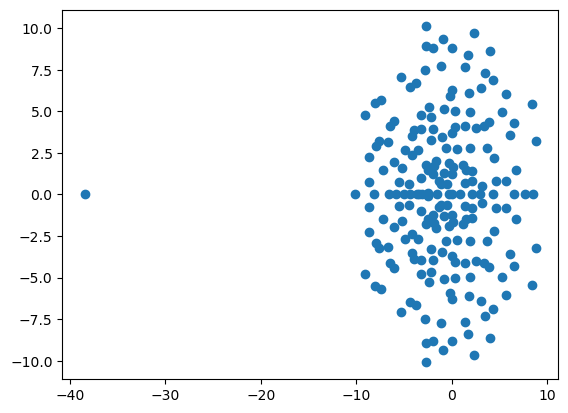

In [16]:
A = gen_init_W(100, 0.25, 3, 10)
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))

In [4]:
A = stabilize(A) 
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))

NameError: name 'stabilize' is not defined

In [144]:
# How severe is the discretization problem with respect to the non-normality claims?
A = np.random.normal(scale=1/(1.5 * np.sqrt(10)), size=(10, 10))
A = 0.5 * (A + A.T) - np.eye(A.shape[0])
while np.max(np.real(np.linalg.eigvals(A))) > 0:
    A = np.random.normal(scale=1/(1.5 * np.sqrt(10)), size=(10, 10))
    A = 0.5 * (A + A.T) - np.eye(A.shape[0])

#A = stabilize(A)
B = np.eye(A.shape[0])
C = np.eye(A.shape[0])

dt = 1
# Tustin discretize
sigma = 2/dt
Ad = (sigma * np.eye(A.shape[0]) + A) @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)
Bd = np.sqrt(2 * sigma) * np.linalg.inv(sigma * np.eye(A.shape[0]) - A) @ B
Cd = np.sqrt(2 * sigma) * C @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)

In [145]:
np.linalg.eigvals(Ad)

array([0.8758167 , 0.61483363, 0.02296373, 0.50880824, 0.10222382,
       0.43284599, 0.35667948, 0.16636726, 0.25146301, 0.26569014])

In [142]:
d = 6
ssr = SSR(A=Ad, B=Bd, C=Cd)
cross_covs = ssr.autocorrelation(10)
cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

cross_covs = torch.tensor(cross_covs)
cross_covs_rev = torch.tensor(cross_covs_rev)

e, Upca = np.linalg.eig(cross_covs[0])
eigorder = np.argsort(e)[::-1]
Upca = Upca[:, eigorder][:, 0:d]

lqgmodel = LQGCA(d=d, T=1)
lqgmodel.cross_covs = cross_covs
lqgmodel.cross_covs_rev = cross_covs_rev

phi = []
scores = []
for i in range(100):
    coef_, score = lqgmodel._fit_projection()
    phi.append(np.mean(scipy.linalg.subspace_angles(Upca, coef_)))
    scores.append(score)

In [143]:
np.unique(phi)

array([0.00369152, 0.00375665, 0.00422811, 0.00602423, 0.00610925,
       0.00614598, 0.00646488, 0.00693507, 0.00735465, 0.00822473,
       0.00834027, 0.00857763, 0.00861104, 0.00903502, 0.00940427,
       0.00970082, 0.00976552, 0.00992444, 0.0099688 , 0.01007543,
       0.01017326, 0.0111505 , 0.01171114, 0.01181653, 0.01219143,
       0.01232985, 0.01240321, 0.01246302, 0.01271347, 0.01299296,
       0.01312021, 0.01320564, 0.01339136, 0.01352165, 0.01352497,
       0.01356033, 0.01369982, 0.01381611, 0.01382207, 0.01389021,
       0.01400796, 0.01419104, 0.01423332, 0.0145417 , 0.01471101,
       0.01474157, 0.01482237, 0.01484685, 0.0148496 , 0.01510197,
       0.01532755, 0.01566885, 0.01567199, 0.01608435, 0.01622068,
       0.01653638, 0.01671572, 0.016829  , 0.0169323 , 0.01708045,
       0.01719832, 0.0172286 , 0.01724337, 0.01739957, 0.01743339,
       0.01754293, 0.017838  , 0.01790736, 0.01793402, 0.01803847,
       0.01809878, 0.01833916, 0.0185149 , 0.01852682, 0.01865

In [134]:
np.array(scores)[np.argsort(phi)]

array([-8.44357431, -8.44357492, -8.44357548, -8.44357502, -8.44357509,
       -8.44357484, -8.44357583, -8.44357529, -8.4435752 , -8.4435765 ,
       -8.44357728, -8.44357853, -8.44357797, -8.44358003, -8.44357904,
       -8.44357767, -8.44357873, -8.44357955, -8.44357885, -8.44357996,
       -8.44358038, -8.44358109, -8.4435814 , -8.44358575, -8.44358883,
       -8.44358488, -8.44359106, -8.44358715, -8.44358421, -8.44358946,
       -8.44359085, -8.44358429, -8.44358605, -8.44358663, -8.44359116,
       -8.44358711, -8.44359405, -8.44358597, -8.44358924, -8.44358796,
       -8.4435926 , -8.44360372, -8.4435924 , -8.44359138, -8.44359925,
       -8.44359335, -8.44359323, -8.44359411, -8.4435958 , -8.44360078,
       -8.44360525, -8.44360457, -8.44360471, -8.4436104 , -8.44360162,
       -8.44360051, -8.44361274, -8.44361767, -8.44361071, -8.4436156 ,
       -8.44360725, -8.44361525, -8.44361251, -8.44362543, -8.44362109,
       -8.44361603, -8.44361471, -8.4436258 , -8.44361823, -8.44

(0.024891620377403757, tensor(-52.2224, dtype=torch.float64))
